# Music Classification using CNN

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import os
import glob
import pretty_midi
import matplotlib.pyplot as plt

In [3]:
# Required to install after pyplot to avoid error
import librosa
import librosa.display

### Data Import

In [4]:
# Function to load MIDI files from a directory using PrettyMIDI (AI Generated Music)
def load_midi_files(data_dir):
    all_files = glob.glob(os.path.join(data_dir, '*/*.mid'))  # get all .mid files in the data_dir
    data = []
    for file in all_files:
        try:
            midi_file = pretty_midi.PrettyMIDI(file)  # load MIDI file
            data.append((os.path.basename(os.path.dirname(file)), midi_file))  # add composer (folder name) and midi file
        except (IOError, pretty_midi.exceptions.StandardError):
            pass  # some MIDI files may be corrupted or not standard MIDI, so skip these
    return data


In [5]:
# Load the data from each training, test, and dev folder
train_data = load_midi_files('./Composer_Dataset/NN_midi_files_extended/train/')  # load the data
test_data = load_midi_files('./Composer_Dataset/NN_midi_files_extended/test/')  # load the data
dev_data = load_midi_files('./Composer_Dataset/NN_midi_files_extended/dev/')  # load the data

# Verify that the data was loaded correctly
print('Number of training examples: ', len(train_data))
print('Number of test examples: ', len(test_data))
print('Number of dev examples: ', len(dev_data))

/Users/trevormcgirr/opt/anaconda3/envs/base2/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of training examples:  369
Number of test examples:  35
Number of dev examples:  35


### Data Exploration

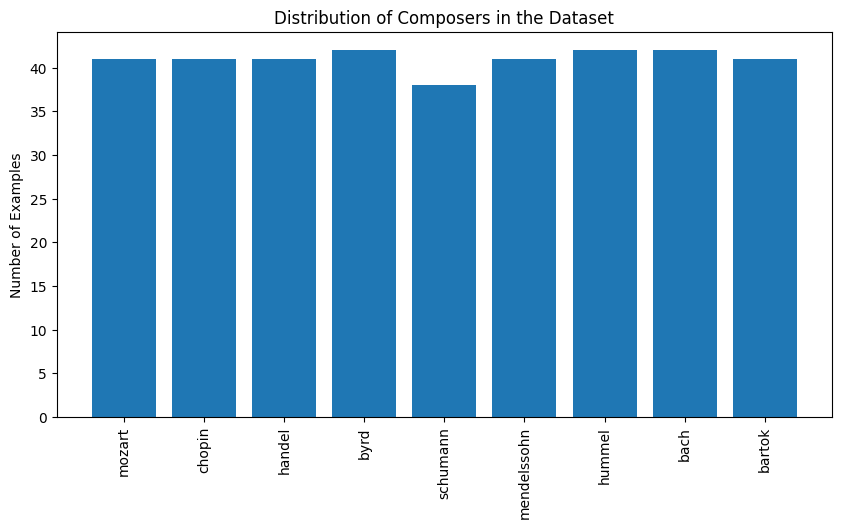

In [6]:
# Plot the distribution of composers in the dataset for the training set
from collections import Counter

def plot_composer_distribution(data):
    composer_names = [name for name, _ in data]
    composer_counts = Counter(composer_names)

    plt.figure(figsize=(10, 5))
    plt.bar(composer_counts.keys(), composer_counts.values())
    plt.title('Distribution of Composers in the Dataset')
    plt.ylabel('Number of Examples')
    plt.xticks(rotation='vertical')
    plt.show()

# Plot
plot_composer_distribution(train_data)  


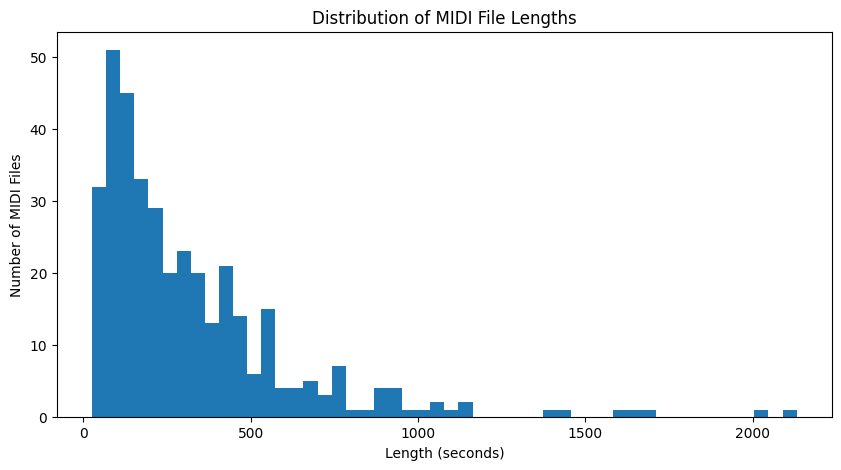

In [7]:
# Plot the distribution for the length of the MIDI files in the training data 
def plot_length_distribution(data):
    lengths = [midi_file.get_end_time() for _, midi_file in data]

    plt.figure(figsize=(10, 5))
    plt.hist(lengths, bins=50)
    plt.title('Distribution of MIDI File Lengths')
    plt.xlabel('Length (seconds)')
    plt.ylabel('Number of MIDI Files')
    plt.show()

# Plot
plot_length_distribution(train_data)


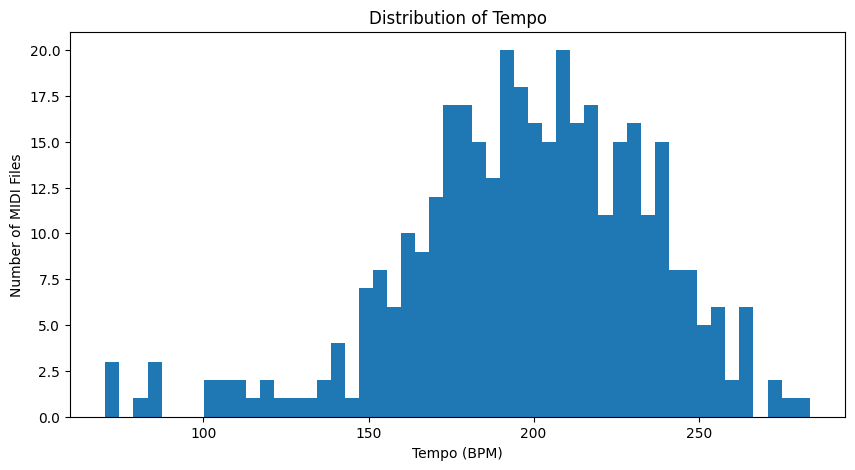

In [8]:
# Plot the distribution of tempos in the training data
def plot_tempo_distribution(data):
    tempos = [midi_file.estimate_tempo() for _, midi_file in data]

    plt.figure(figsize=(10, 5))
    plt.hist(tempos, bins=50)
    plt.title('Distribution of Tempo')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Number of MIDI Files')
    plt.show()

# Plot
plot_tempo_distribution(train_data)


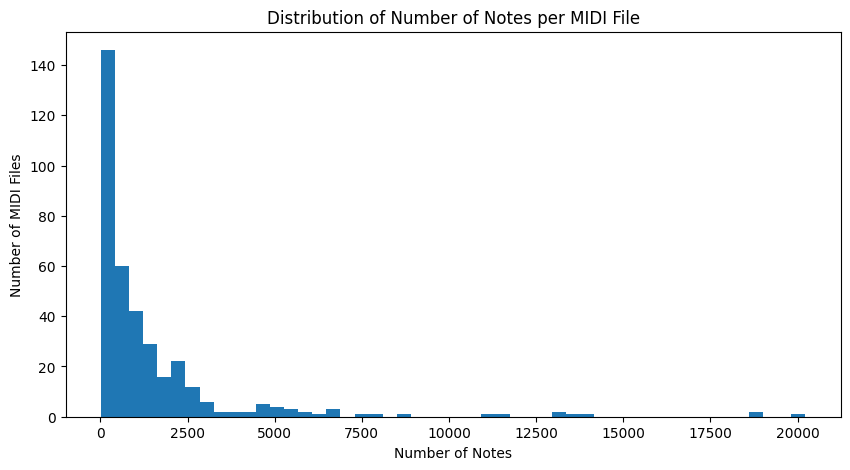

In [9]:
# Plot the distribution of number of notes in the training data
def plot_notes_distribution(data):
    num_notes = [len(midi_file.instruments[0].notes) for _, midi_file in data]

    plt.figure(figsize=(10, 5))
    plt.hist(num_notes, bins=50)
    plt.title('Distribution of Number of Notes per MIDI File')
    plt.xlabel('Number of Notes')
    plt.ylabel('Number of MIDI Files')
    plt.show()

# Plot
plot_notes_distribution(train_data)


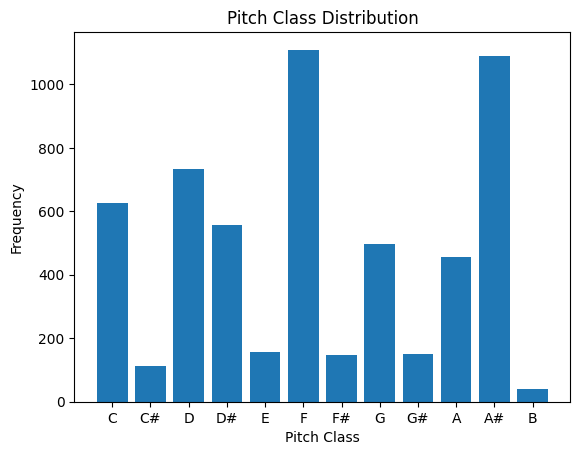

In [10]:
def plot_pitch_class_distribution(midi):
    # Get a list of all pitches in the MIDI file
    pitches = [note.pitch for instrument in midi.instruments for note in instrument.notes]

    # Compute the count of each pitch class
    pitch_classes = [pitch % 12 for pitch in pitches]
    counts = np.bincount(pitch_classes, minlength=12)

    # Plot the results
    plt.bar(np.arange(12), counts)
    plt.xlabel('Pitch Class')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    plt.title('Pitch Class Distribution')
    plt.show()

plot_pitch_class_distribution(train_data[0][1])  # assuming training_data[0][1] is a PrettyMIDI object


/var/folders/8t/_x4qcscx7txf2l7h7tx1jwgr0000gn/T/ipykernel_8349/186494203.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(midi.get_piano_roll(fs)[start_pitch:end_pitch],


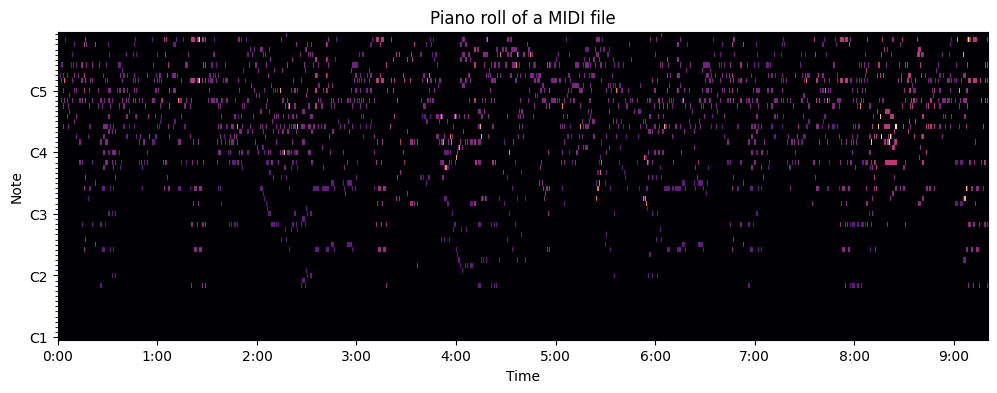

In [11]:
def plot_piano_roll(midi, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(midi.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(12, 4))
plot_piano_roll(train_data[0][1], 24, 84)  # assuming training_data[0][1] is a PrettyMIDI object
plt.title('Piano roll of a MIDI file')
plt.show()


/var/folders/8t/_x4qcscx7txf2l7h7tx1jwgr0000gn/T/ipykernel_8349/1969295580.py:11: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(24), hop_length=1, sr=10)


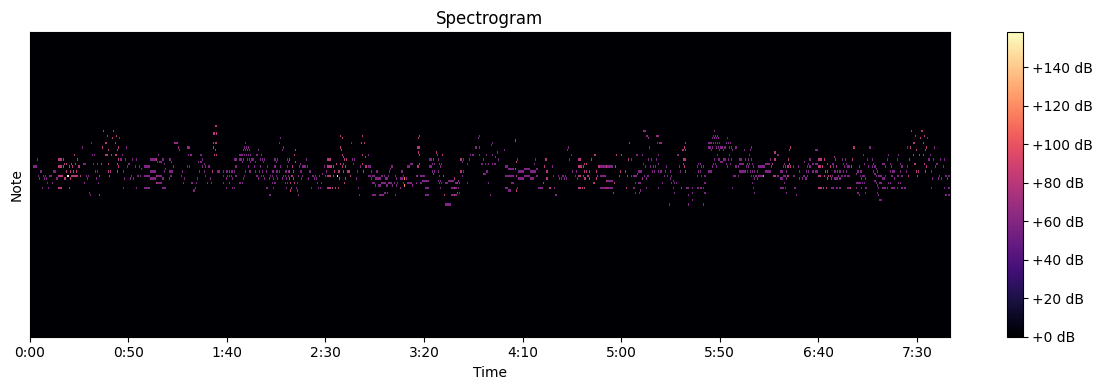

In [12]:
def plot_piano_roll_for_instrument(midi_data, instrument_program):
    for instrument in midi_data.instruments:
        if instrument.program == instrument_program:
            piano_roll = instrument.get_piano_roll(fs=10)
            break
    else:
        print("Instrument not found in this MIDI file.")
        return

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(24), hop_length=1, sr=10)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

# For example, to visualize the piano roll of the Piano instrument in the second MIDI file in your training dataset:
plot_piano_roll_for_instrument(train_data[1][1], pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))

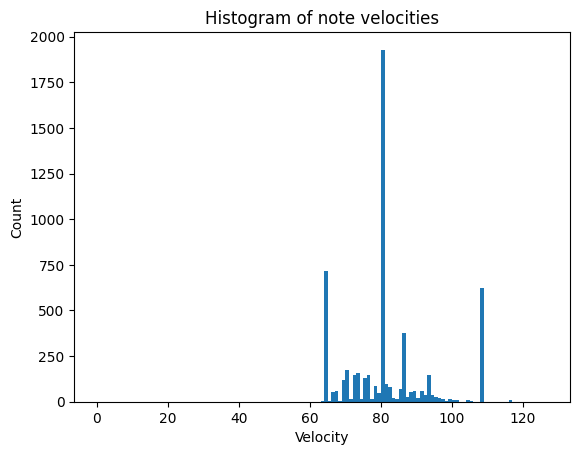

In [13]:
def plot_velocity_histogram(midi_data):
    velocities = [note.velocity for instrument in midi_data.instruments for note in instrument.notes]

    plt.hist(velocities, bins=range(0, 128))
    plt.title('Histogram of note velocities')
    plt.xlabel('Velocity')
    plt.ylabel('Count')
    plt.show()

# For example, to visualize the velocity histogram of the first MIDI file in your training dataset:
plot_velocity_histogram(train_data[0][1])


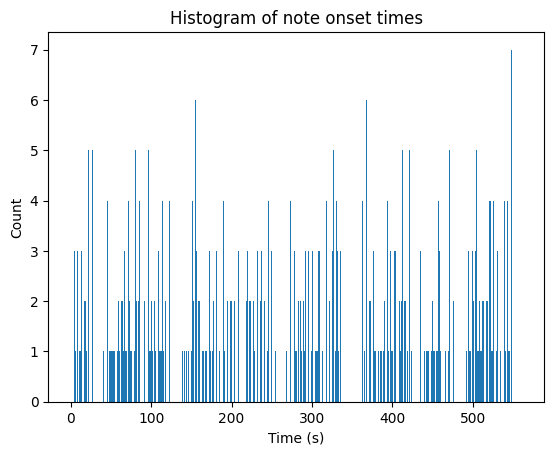

In [14]:
def plot_onset_histogram(midi_data):
    onsets = [note.start for instrument in midi_data.instruments for note in instrument.notes]

    plt.hist(onsets, bins=np.arange(0, midi_data.get_end_time(), 0.1))
    plt.title('Histogram of note onset times')
    plt.xlabel('Time (s)')
    plt.ylabel('Count')
    plt.show()

# For example, to visualize the onset histogram of the first MIDI file in your training dataset:
plot_onset_histogram(train_data[0][1])


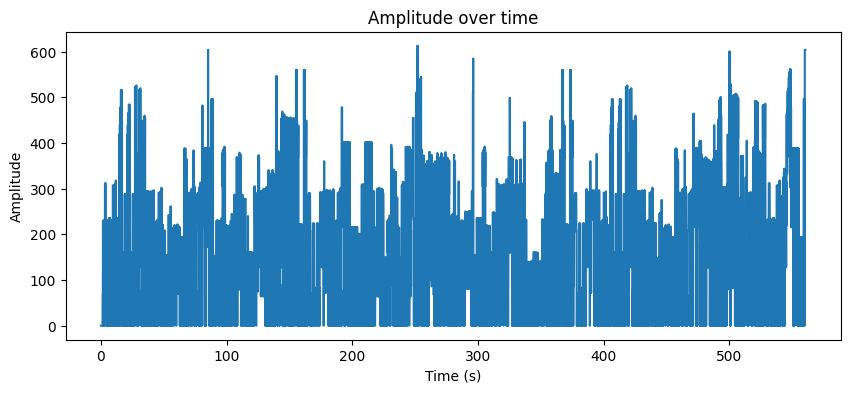

In [15]:
# Not sure if this is valuable

def plot_amplitude_over_time(midi_data, fs=100):
    # Create the piano roll matrix
    piano_roll = midi_data.get_piano_roll(fs)

    # Sum along the pitch axis
    amplitude_over_time = np.sum(piano_roll, axis=0)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, midi_data.get_end_time(), amplitude_over_time.shape[0]), amplitude_over_time)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Amplitude over time')
    plt.show()

# For example, to visualize the amplitude over time of the first MIDI file in your training dataset:
plot_amplitude_over_time(train_data[0][1])

In [16]:
# List instruments used in the MIDI file
def get_instruments(midi_data):
    instruments = set()
    for instrument in midi_data.instruments:
        instruments.add(pretty_midi.program_to_instrument_name(instrument.program))
    return list(instruments)

# For example, to get the instruments in the first MIDI file in your training dataset:
# print(get_instruments(train_data[0][1]))

In [17]:
def plot_piano_roll_for_instruments(midi_data, instrument_names):
    for instrument_name in instrument_names:
        for instrument in midi_data.instruments:
            if instrument.program == pretty_midi.instrument_name_to_program(instrument_name):
                piano_roll = instrument.get_piano_roll(fs=10)
                break
        else:
            print(f"{instrument_name} not found in this MIDI file.")
            continue

        plt.figure(figsize=(12, 4))
        librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(24), hop_length=1, sr=10)
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'{instrument_name}')
        plt.tight_layout()
        plt.show()

# For example, to visualize the piano roll of the Acoustic Grand Piano and Violin in the second MIDI file in your training dataset:
# plot_piano_roll_for_instruments(train_data[2][1], ['Acoustic Grand Piano', 'Violin', 'Cello', 'Flute', 'Clarinet', 'Trumpet', 'Acoustic Bass', 'Oboe' ])



/var/folders/8t/_x4qcscx7txf2l7h7tx1jwgr0000gn/T/ipykernel_8349/877155913.py:12: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(piano_roll, x_axis='time', y_axis='cqt_note', fmin=pretty_midi.note_number_to_hz(24), hop_length=1, sr=10)


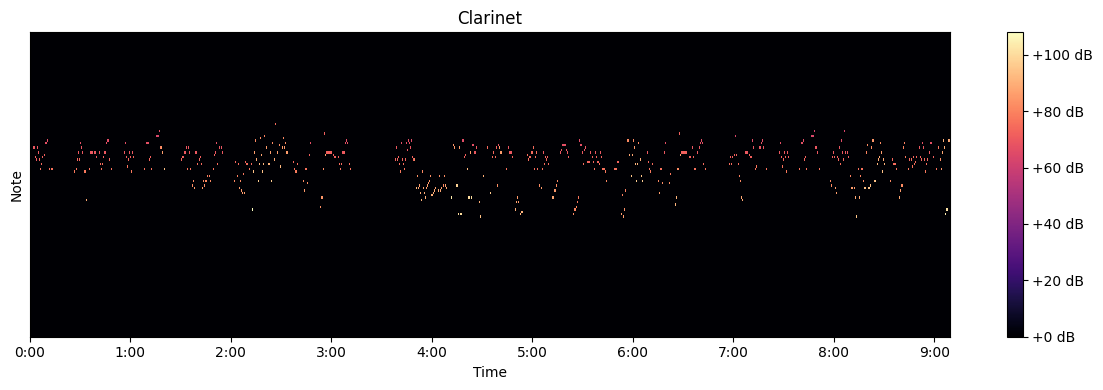

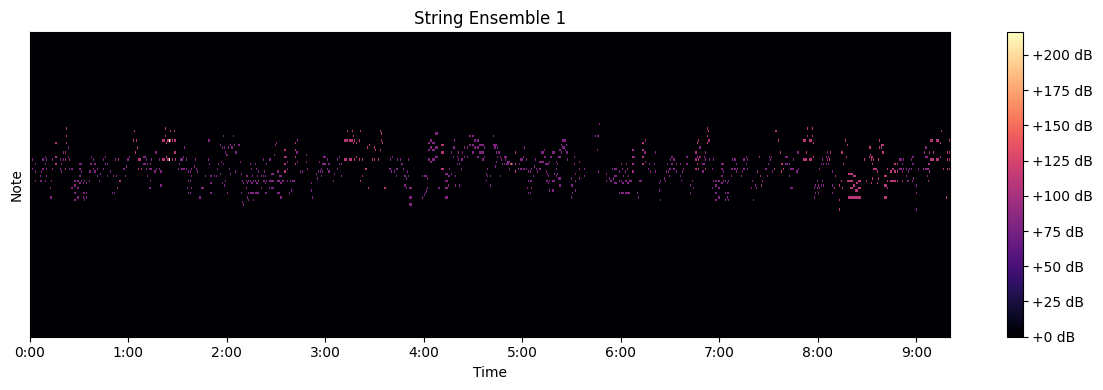

In [18]:
# Plot for instruments listed
instruments = get_instruments(train_data[0][1])
plot_piano_roll_for_instruments(train_data[0][1], instruments)

## Data Pre-processing

In [19]:
# Function to convert the midi files to wav
!pip3 install midi2audio
from midi2audio import FluidSynth

def midi_to_wav(midi_file_path, wav_file_path):
    fs = FluidSynth('/usr/local/Cellar/fluid-synth/2.3.3/share/soundfonts/GeneralUser GS MuseScore v1.442.sf2')
    fs.midi_to_audio(midi_file_path, wav_file_path)
     
def convert_all_midi_to_wav(input_dir, output_dir):
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.mid'):
                # Get the full path to the MIDI file
                input_file = os.path.join(root, file)

                # Create a corresponding path in the output directory
                output_file = os.path.join(output_dir, os.path.relpath(input_file, input_dir))
                output_file = os.path.splitext(output_file)[0] + '.wav'
                
                # Check if the output WAV file already exists
                if os.path.exists(output_file):
                    print(f'{output_file} already exists, skipping...')
                    continue

                # Ensure the output directory exists
                os.makedirs(os.path.dirname(output_file), exist_ok=True)
                
                # Convert the MIDI file to a WAV file
                print(f'Converting {input_file} to {output_file}...')
                midi_to_wav(input_file, output_file)  


In [20]:
# Convert the MIDI files to WAV files

# Set the directories for the MIDI and WAV files
base_midi_data_dir = './Composer_Dataset/NN_midi_files_extended/'
base_wav_data_dir = 'wav/'

# List of main directories like -dev, -test, -train
main_dirs = ['dev', 'test', 'train']

for main_dir in main_dirs:
    midi_data_dir = os.path.join(base_midi_data_dir, main_dir)
    wav_data_dir = os.path.join(base_wav_data_dir, f"{main_dir}")

    # Get all composer directories
    composer_dirs = os.listdir(midi_data_dir)

    # Create a new WAV directory for each composer
    for composer in composer_dirs:
        composer_midi_dir = os.path.join(midi_data_dir, composer)
        composer_wav_dir = os.path.join(wav_data_dir, composer)
        
        # Convert all MIDI files in this composer's directory to WAV
        convert_all_midi_to_wav(composer_midi_dir, composer_wav_dir)


wav/dev/mozart/mozart039.wav already exists, skipping...
wav/dev/mozart/mozart035.wav already exists, skipping...
wav/dev/mozart/mozart020.wav already exists, skipping...
wav/dev/mozart/mozart040.wav already exists, skipping...
wav/dev/chopin/chopin069.wav already exists, skipping...
wav/dev/chopin/chopin087.wav already exists, skipping...
wav/dev/chopin/chopin061.wav already exists, skipping...
wav/dev/chopin/chopin070.wav already exists, skipping...
wav/dev/handel/handel106.wav already exists, skipping...
wav/dev/handel/handel139.wav already exists, skipping...
wav/dev/handel/handel145.wav already exists, skipping...
wav/dev/handel/handel119.wav already exists, skipping...
wav/dev/byrd/byrd180.wav already exists, skipping...
wav/dev/byrd/byrd168.wav already exists, skipping...
wav/dev/byrd/byrd184.wav already exists, skipping...
wav/dev/byrd/byrd152.wav already exists, skipping...
wav/dev/schumann/schumann217.wav already exists, skipping...
wav/dev/schumann/schumann238.wav already ex

In [22]:
# Sanity check to make sure that all MIDI files have corresponding WAV files
def verify_midi_wav_match(midi_dir, wav_dir):
    # List all midi and wav files
    midi_files = [f for f in os.listdir(midi_dir) if f.endswith('.mid')]
    wav_files = [f for f in os.listdir(wav_dir) if f.endswith('.wav')]

    # Strip extensions for comparison
    midi_names = {os.path.splitext(f)[0] for f in midi_files}
    wav_names = {os.path.splitext(f)[0] for f in wav_files}

    missing_wav_files = midi_names - wav_names
    extra_wav_files = wav_names - midi_names

    if not missing_wav_files and not extra_wav_files:
        print("All files are accounted for/matching.")
    else:
        if missing_wav_files:
            print("Missing WAV files for these MIDI files:")
            for name in missing_wav_files:
                print(name + ".mid")
            print()

        if extra_wav_files:
            print("Extra WAV files (not corresponding to any MIDI):")
            for name in extra_wav_files:
                print(name + ".wav")


base_midi_data_dir = './Composer_Dataset/NN_midi_files_extended/'
base_wav_data_dir = 'wav/'

# List of main directories like -dev, -test, -train
main_dirs = ['dev', 'test', 'train']

for main_dir in main_dirs:
    midi_data_subdir = os.path.join(base_midi_data_dir, main_dir)
    wav_data_subdir = os.path.join(base_wav_data_dir, main_dir)

    # Only consider actual directories, filtering out files
    composer_dirs = [d for d in os.listdir(midi_data_subdir) if os.path.isdir(os.path.join(midi_data_subdir, d))]

    for composer in composer_dirs:
        composer_midi_dir = os.path.join(midi_data_subdir, composer)
        composer_wav_dir = os.path.join(wav_data_subdir, composer)

        print(f"Verifying for {composer}:")
        verify_midi_wav_match(composer_midi_dir, composer_wav_dir)
        print("------------------------------")


Verifying for mozart:
All files are accounted for/matching.
------------------------------
Verifying for chopin:
All files are accounted for/matching.
------------------------------
Verifying for handel:
All files are accounted for/matching.
------------------------------
Verifying for byrd:
All files are accounted for/matching.
------------------------------
Verifying for schumann:
All files are accounted for/matching.
------------------------------
Verifying for mendelssohn:
All files are accounted for/matching.
------------------------------
Verifying for hummel:
All files are accounted for/matching.
------------------------------
Verifying for bach:
All files are accounted for/matching.
------------------------------
Verifying for bartok:
All files are accounted for/matching.
------------------------------
Verifying for mozart:
All files are accounted for/matching.
------------------------------
Verifying for chopin:
All files are accounted for/matching.
---------------------------

## Feature Extraction

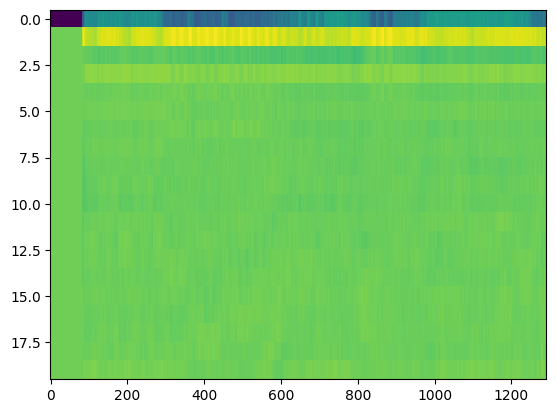

In [26]:
# Visualization of MFCCs
def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

test_file = 'wav/train/mozart/mozart000.wav'
mfcc = get_mfcc(test_file)
plt.imshow(mfcc, interpolation='nearest', aspect='auto')
plt.show()

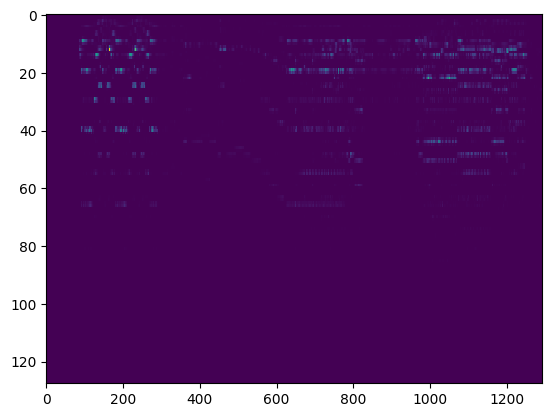

In [27]:
# Visualization of the melspectrogram
def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=30)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

melspectrogram = get_melspectrogram(test_file)
plt.imshow(melspectrogram, interpolation='nearest', aspect='auto')
plt.show()

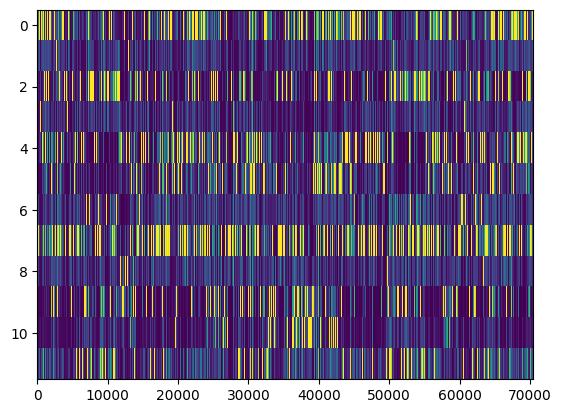

In [28]:
# Visualization of chroma vector
def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

chroma = get_chroma_vector(test_file)
plt.imshow(chroma, interpolation='nearest', aspect='auto')
plt.show()

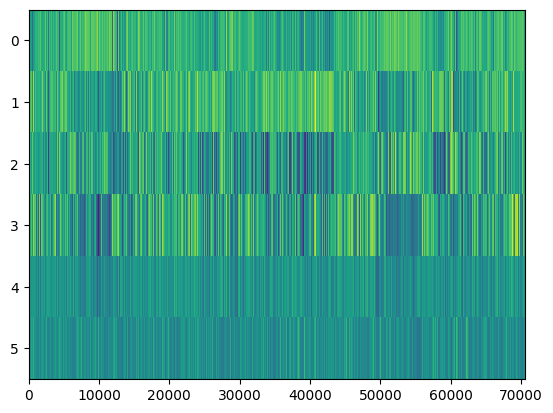

In [ ]:
# Visalization of the tonnetz feature
def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

tntz = get_tonnetz(test_file)
plt.imshow(tntz , interpolation='nearest', aspect='auto')
plt.show()

In [30]:
# FUnction to extract each feature from audio file
def get_feature(file_path):
  # Extracting MFCC feature
  mfcc = get_mfcc(file_path)
  mfcc_mean = mfcc.mean(axis=1)
  mfcc_min = mfcc.min(axis=1)
  mfcc_max = mfcc.max(axis=1)
  mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max) )

  # Extracting Mel Spectrogram feature
  melspectrogram = get_melspectrogram(file_path)
  melspectrogram_mean = melspectrogram.mean(axis=1)
  melspectrogram_min = melspectrogram.min(axis=1)
  melspectrogram_max = melspectrogram.max(axis=1)
  melspectrogram_feature = np.concatenate( (melspectrogram_mean, melspectrogram_min, melspectrogram_max) )

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  chroma_min = chroma.min(axis=1)
  chroma_max = chroma.max(axis=1)
  chroma_feature = np.concatenate( (chroma_mean, chroma_min, chroma_max) )

  # Extracting tonnetz feature
  tntz = get_tonnetz(file_path)
  tntz_mean = tntz.mean(axis=1)
  tntz_min = tntz.min(axis=1)
  tntz_max = tntz.max(axis=1)
  tntz_feature = np.concatenate( (tntz_mean, tntz_min, tntz_max) ) 
  
  feature = np.concatenate( (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature) )
  return feature

In [32]:
train_directory = 'wav/train'
dev_directory = 'wav/dev'
test_directory = 'wav/test'
composers = ['bach', 'bartok', 'byrd', 'chopin', 'handel', 'hummel', 'mendelssohn', 'mozart', 'schumann']

features_train, labels_train = [], []
features_dev, labels_dev = [], []
features_test, labels_test = [], []

directories = [(train_directory, features_train, labels_train),
               (dev_directory, features_dev, labels_dev),
               (test_directory, features_test, labels_test)]

for directory, features, labels in directories:
    for composer in composers:
        print(f"Calculating features for composer: {composer} in directory: {directory}")
        composer_path = os.path.join(directory, composer)
        for file in os.listdir(composer_path):
            file_path = os.path.join(composer_path, file)
            print(f"Processing {file_path}...")  # Print the file being processed

            try:
                features.append(get_feature(file_path))  # Assuming you have a function called get_feature
                label = composers.index(composer)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# shape 
print("Train features shape:", np.array(features_train).shape)
print("Train labels shape:", np.array(labels_train).shape)

print("Dev features shape:", np.array(features_dev).shape)
print("Dev labels shape:", np.array(labels_dev).shape)

print("Test features shape:", np.array(features_test).shape)
print("Test labels shape:", np.array(labels_test).shape)



Calculating features for composer: bach in directory: wav/train
Processing wav/train/bach/bach389.wav...
Processing wav/train/bach/bach362.wav...
Processing wav/train/bach/bach377.wav...
Processing wav/train/bach/bach363.wav...
Processing wav/train/bach/bach388.wav...
Processing wav/train/bach/bach375.wav...
Processing wav/train/bach/bach361.wav...
Processing wav/train/bach/bach360.wav...
Processing wav/train/bach/bach374.wav...
Processing wav/train/bach/bach358.wav...
Processing wav/train/bach/bach370.wav...
Processing wav/train/bach/bach364.wav...
Processing wav/train/bach/bach365.wav...
Processing wav/train/bach/bach371.wav...
Processing wav/train/bach/bach367.wav...
Processing wav/train/bach/bach373.wav...
Processing wav/train/bach/bach372.wav...
Processing wav/train/bach/bach366.wav...
Processing wav/train/bach/bach380.wav...
Processing wav/train/bach/bach343.wav...
Processing wav/train/bach/bach357.wav...
Processing wav/train/bach/bach342.wav...
Processing wav/train/bach/bach381.

## Model Building

In [33]:
# !pip3 install tensorflow
from tensorflow import keras
import tensorflow as tf

2023-08-07 10:01:28.149873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [119]:
# Build Model
# Define Input 
inputs = keras.Input(shape=(498,), name="feature")

# Layer 1
x = keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), name="dense_1")(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)

# Layer 2
x = keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), name="dense_2")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)

# Output Layer
outputs = keras.layers.Dense(9, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
            #   metrics=[keras.metrics.SparseCategoricalAccuracy()])
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model_checkpoint = keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss')

# Convert the data to tensors
features_train_tensor = tf.convert_to_tensor(features_train)
labels_train_tensor = tf.convert_to_tensor(labels_train)

features_dev_tensor = tf.convert_to_tensor(features_dev)
labels_dev_tensor = tf.convert_to_tensor(labels_dev)

history = model.fit(
    x=features_train_tensor,
    y=labels_train_tensor,
    verbose=1,
    validation_data=(features_dev_tensor, labels_dev_tensor),
    epochs=100,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)



Epoch 1/300
12/12 [==============================] - 2s 26ms/step - loss: 2.6007 - sparse_categorical_accuracy: 0.1762 - val_loss: 8.4076 - val_sparse_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 2/300
12/12 [==============================] - 0s 9ms/step - loss: 2.0887 - sparse_categorical_accuracy: 0.3089 - val_loss: 5.3459 - val_sparse_categorical_accuracy: 0.1143 - lr: 0.0010
Epoch 3/300
12/12 [==============================] - 0s 9ms/step - loss: 1.8272 - sparse_categorical_accuracy: 0.3930 - val_loss: 4.3191 - val_sparse_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 4/300
12/12 [==============================] - 0s 9ms/step - loss: 1.6959 - sparse_categorical_accuracy: 0.4526 - val_loss: 3.3603 - val_sparse_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 5/300
12/12 [==============================] - 0s 10ms/step - loss: 1.6271 - sparse_categorical_accuracy: 0.4661 - val_loss: 2.7230 - val_sparse_categorical_accuracy: 0.1429 - lr: 0.0010
Epoch 6/300
12/12 [===================

## Model Evaluation

In [120]:
features_test_tensor = tf.convert_to_tensor(features_test)
labels_test_tensor = tf.convert_to_tensor(labels_test)

scores = model.evaluate(x=features_test_tensor, y=labels_test_tensor, verbose=1)
print('Loss:', scores[0])
print('Accuracy:', scores[1])
print('Precision:', scores[2])
print('Recall:', scores[3])



2/2 [==============================] - 0s 4ms/step - loss: 1.0977 - sparse_categorical_accuracy: 0.7429
[1.0977402925491333, 0.7428571581840515]
Test loss: 1.0977402925491333
Test accuracy: 0.7428571581840515


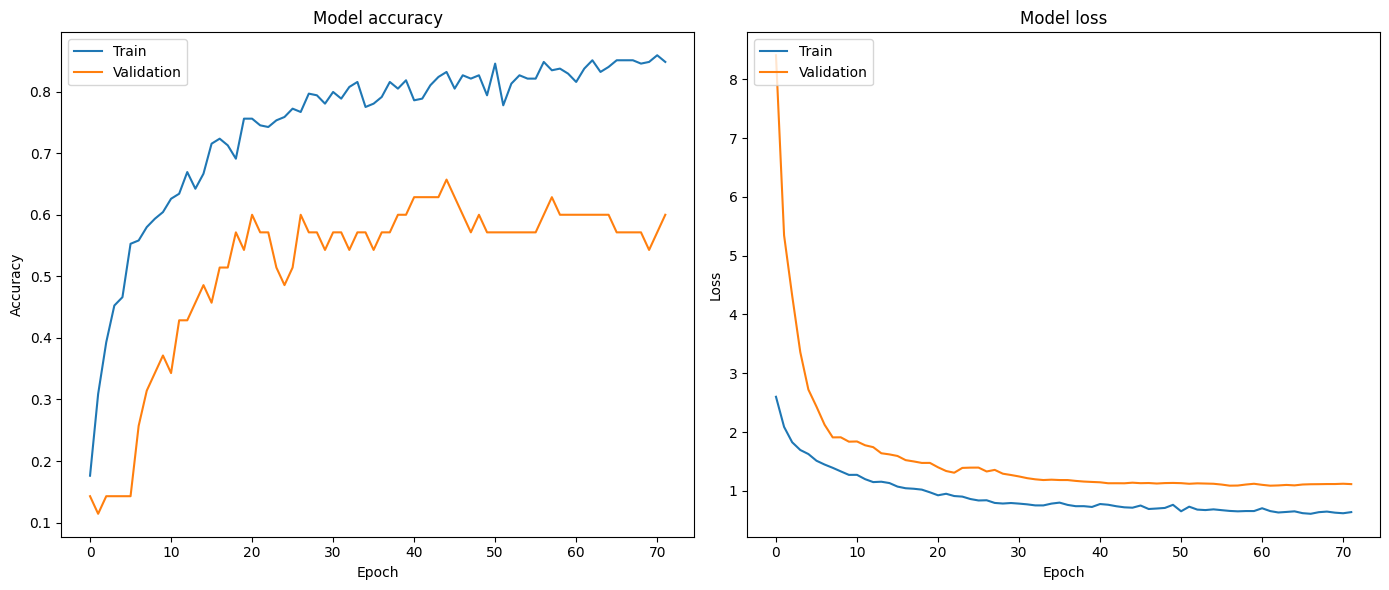

In [121]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()